# Final Project Submission

Please fill out:
* Student name: Collin Loo
* Student pace: part time
* Scheduled project review date/time: TBA
* Instructor name: James M Irving, Ph.D.
* Blog post URL: TBA


## Project Roadmap

#### Objectives:
The objective of this project is to produce a classification model that will predict if customers will cease their telephone services with Syria Tel.

#### Business Case:
The targeted audience will be the sales and customer services of the company.  The model will provides the audience with insights as to why we might lose a customer's subscription.  Knowing these factors is critical as we can take corrective and preventive actions to retain the customers and prevent revenue loss.

#### Project Approach
We will follows the OSEMN framework during the project execution.  In addition, we will develop and fine tune 4 classification models using Logistic Regression, K-Nearest Neighbors, Random Forest and XGBoost.  The model that produces the best recall score will be adopted.

***
## Obtain Data

### Import Libraries

In [117]:
# Import various libraries
import time
from time import process_time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from myFunc import *
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### Import Data

In [118]:
# Import the dataset
df = pd.read_csv(r'csv\bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


***
## Clean and Scrub Data

### Inpect Columns Data Type

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The dataset contains both numerical and categorical data type.  One hot encoding will be required.</li>
        <li>Phone number column can be dropped as it doesn't provide useful information to the model.</li>
        <li>Churn column will be our labels.  We will change its bool data type to int64.</li>
    </ul>
</div>

In [120]:
# Drop the phone number column
df.drop(columns='phone number', axis=1, inplace=True)

# Confirm drop
(df.columns == 'phone number').sum()

0

In [121]:
# Convert boolean to interger
df['churn'] = df['churn'].map({True:1, False:0})

# Verify changes
df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

### Inspect Unique Values in Columns

In [122]:
df.nunique()

state                       51
account length             212
area code                    3
international plan           2
voice mail plan              2
number vmail messages       46
total day minutes         1667
total day calls            119
total day charge          1667
total eve minutes         1611
total eve calls            123
total eve charge          1440
total night minutes       1591
total night calls          120
total night charge         933
total intl minutes         162
total intl calls            21
total intl charge          162
customer service calls      10
churn                        2
dtype: int64

In [123]:
df.select_dtypes(object).nunique()

state                 51
international plan     2
voice mail plan        2
dtype: int64

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>There are 51 unique values in the state column.  To keep the model simple, we will group states by region.</li>
        <li>We will use the States to Region mapping obtained from <a href="https://github.com/cphalpert/census-regions/blob/master/us%20census%20bureau%20regions%20and%20divisions.csv"</a>Github</li>
    </ul>
</div>

In [124]:
# Import the States to Region mapping dataset
df_reg = pd.read_csv('csv\st_to_rg.csv')
df_reg.head()

,state,region
0,AK,West
1,AL,South
2,AR,South
3,AZ,West
4,CA,West


In [125]:
# Merge the two dataframe
df_reg = pd.merge(df, df_reg, on='state', )
df_reg.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,...,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,region
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,16.78,244.7,91,11.01,10.0,3,2.70,1,0,Midwest
1,KS,70,408,no,no,0,232.1,122,39.46,292.3,...,24.85,201.2,112,9.05,0.0,0,0.00,3,0,Midwest
2,KS,92,408,yes,no,0,62.6,111,10.64,180.6,...,15.35,221.7,80,9.98,10.4,2,2.81,1,1,Midwest
3,KS,137,408,no,no,0,205.9,88,35.00,209.3,...,17.79,289.9,84,13.05,14.5,4,3.92,2,0,Midwest
4,KS,132,415,no,no,0,83.4,110,14.18,232.2,...,19.74,146.7,114,6.60,7.6,5,2.05,1,0,Midwest


In [126]:
# Drop the state column
df_reg.drop(columns='state', axis=1, inplace=True)

# Verify drop and check unique values
df_reg.select_dtypes(object).nunique()

international plan    2
voice mail plan       2
region                4
dtype: int64

### Check Null Values

In [127]:
# Check for null values
df_reg.isna().sum()

account length            0
area code                 0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
region                    0
dtype: int64

***
## Explore Data

### Descriptive Analysis

In [128]:
# Get descriptive analysis of the dataframe
df_reg.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Some columns exhibit great variances.  Data normalization will be required.</li>
        <li>No details can be found regarding the unit for "account length".  However, based on the "total day calls" values, it is safe to assume the unit for "account length" is in days.</li>
        <li>Based on the above assumption, the data seems to represent new customers as the max value in "account length" is 243 days or 8.1 months.</li>
    </ul>
</div>

### Investigate Churn Column

***** Churn Ratio: *****
 0: 85.51%.  1: 14.49%



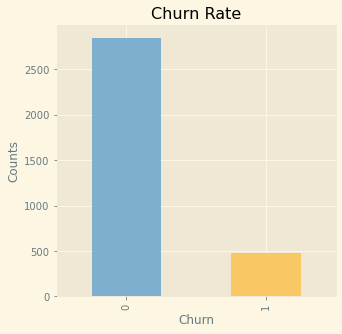

In [129]:
# Checking churn data distribution
nc_percent = round(df_reg.churn.value_counts(normalize=True)[0]*100,2)
c_percent = round(df_reg.churn.value_counts(normalize=True)[1]*100,2)
print(f'***** Churn Ratio: *****\n 0: {nc_percent}%.  1: {c_percent}%\n')
with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(5,5))
    df_reg['churn'].value_counts().plot(kind='bar', color=['#7FAFCE','#F9C764'])
    plt.xlabel('Churn')
    plt.ylabel('Counts')
    plt.title('Churn Rate')
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>15% of the customers in the dataset canceled their services.</li>
        <li>The dataset is clearly unbalanced. Resampling techniques will be required.</li>
    </ul>
</div>

### Check Columns Features Correlation with Churn

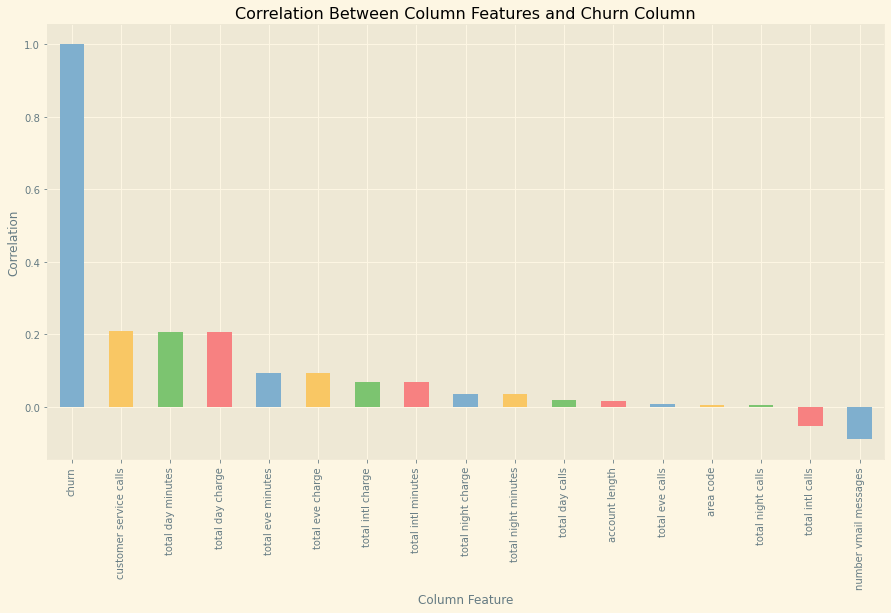

In [130]:
#Get Correlation of "Churn" with other variables:
with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(15,8))
    df_reg.corr()['churn'].sort_values(
                                       ascending = False).plot(kind='bar',
                                       color=['#7FAFCE','#F9C764','#7CC470', '#F78181'])
    plt.xlabel('Column Feature')
    plt.ylabel('Correlation')
    plt.title('Correlation Between Column Features and Churn Column')
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>None of the column feature shows a strong correlation with the churn feature.</li>
        <li>Two column features display a inverse correlation with the churn column, namely 'total intl calls' and 'number vmail messages'.</li>
    </ul>
</div>

### Check Column Features by Churn

In [131]:
# Get categorical and numerical column names
cat_fea = df_reg.select_dtypes(object).columns
int_fea = df_reg.select_dtypes('int64').columns
flt_fea = df_reg.select_dtypes('float64').columns

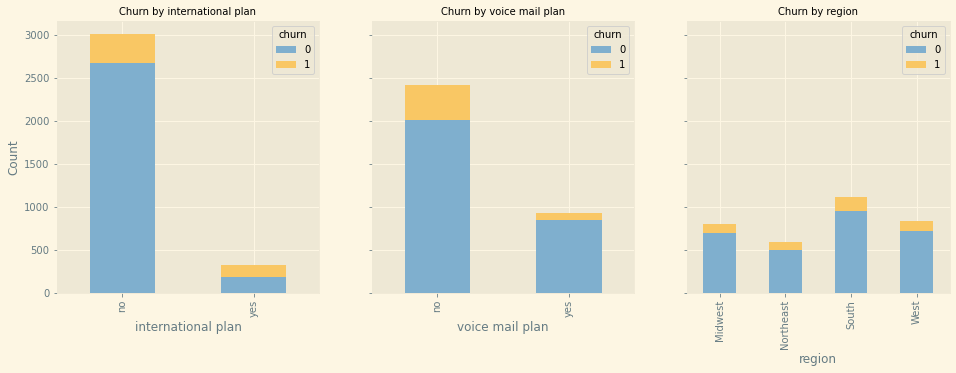

In [132]:
# Plot the churn rate by categorical features
with plt.style.context('Solarize_Light2'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5), sharey=True)
    for xcol, ax in zip(cat_fea, axes):
        df_reg.groupby([xcol, 'churn']).size().unstack().plot(kind='bar', stacked=True, ax=ax,
                                                              color=['#7FAFCE','#F9C764'])
        ax.set_ylabel('Count')
        ax.set_title(f'Churn by {xcol}', size=10)

In [133]:
# Calculate 'churn' rates in each respective regions
(round(df_reg.groupby('region')['churn'].value_counts(normalize=True)* 100, 2)
.astype(str) + '%')

region     churn
Midwest    0        87.03%
           1        12.97%
Northeast  0        83.08%
           1        16.92%
South      0        85.21%
           1        14.79%
West       0        86.16%
           1        13.84%
Name: churn, dtype: object

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>True churn rates are higher for customers with an international plan.  Almost half of the international plan subscribers cancel their services while only a small portion of the customers without a international plan cancel their accounts.</li>
        <li>Customers without the voice mail plan have substantial more true churn rates.</li>
        <li>True churn rate with respect to each region are about on the same level.  Northeast is approximately 4% higher than the region with the lowest true churn rates.</li>
    </ul>
</div>

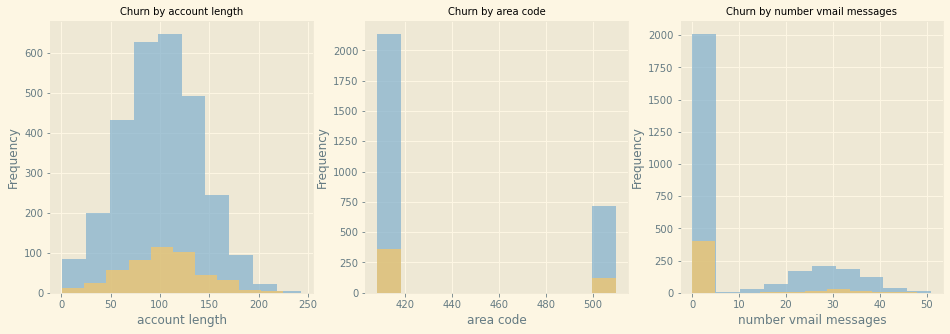

In [134]:
# Plot churn rate by numerical features
fea_churn_plot(df_reg, int_fea, (0,3))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>True churn rate is at the highest when customers have the services for 3 months or so. We wonder this could be due to some type of promotional periods expiring and people are cancelling their services.</li>
        <li>There are only 3 area codes for 51 states, which doesn't add up.  We will drop the column. </li>
        <li>Customers with very few voice mail messages tend to have a higher true churn rate.</li>
    </ul>
</div>

In [135]:
# Drop the area code column
df_reg.drop(columns='area code', axis=1, inplace=True)

# Verify drop
(df_reg.columns == 'area code').sum()

0

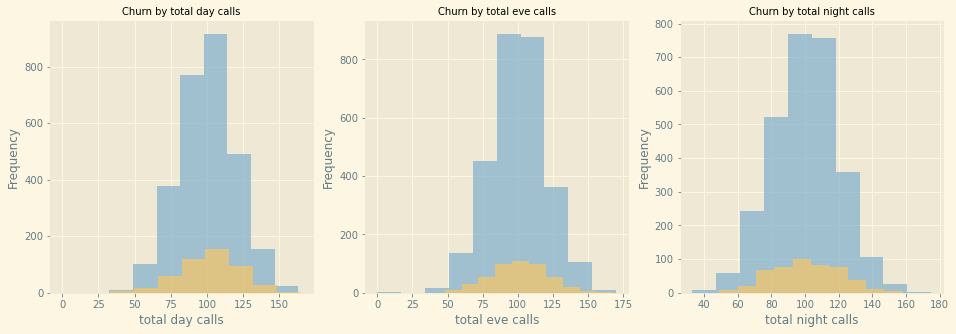

In [136]:
# Plot numerical churn rate by numerical features
fea_churn_plot(df_reg, int_fea, (3,6))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Across all three plots, highest true churn rate can be found associated with customers making about 100 calls throughout day, eve and night call categories.</li>
    </ul>
</div>

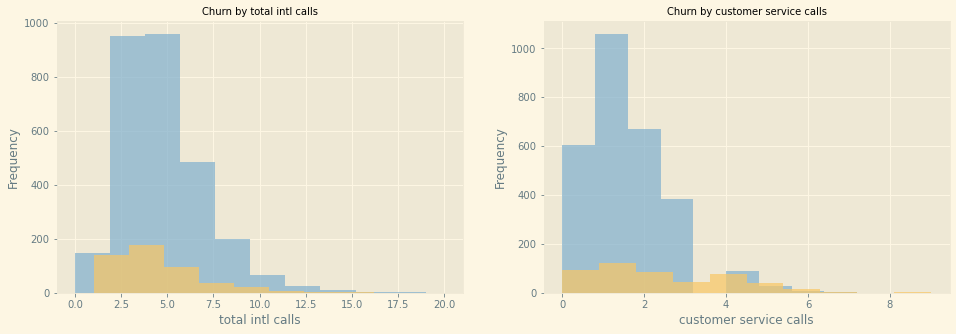

In [137]:
# Plot numerical churn rate by numerical features
fea_churn_plot(df_reg, int_fea, (6,8))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The true churn rate by total international calls seems to be proportionally related to false churn rates.  Both display similar data distribution.</li>
        <li>True churn rates seem to be right skewed.  This indicates that the more the customers contact the service department, the more likey they will churn.</li>
    </ul>
</div>

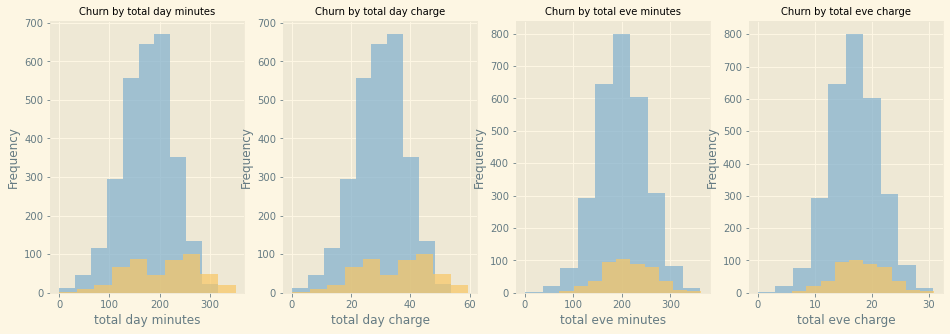

In [138]:
# Plot numerical churn rate by numerical features
fea_churn_plot(df_reg, flt_fea, (0,4))

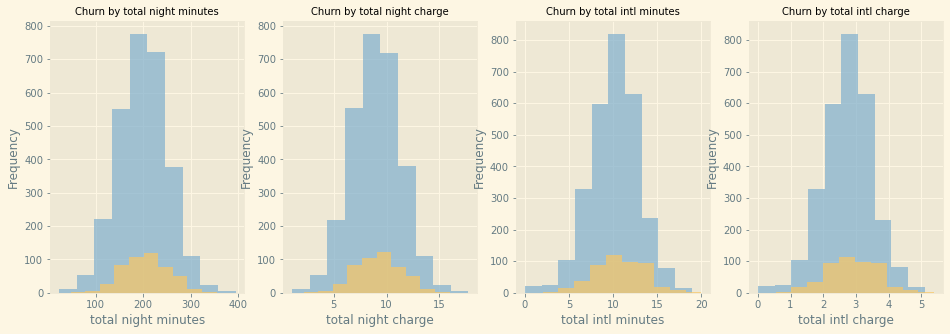

In [139]:
# Plot numerical churn rate by numerical features
fea_churn_plot(df_reg, flt_fea, (4,8))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Most true churn rates occur around the mean of the column features.</li>
        <li>Total day minutes and total day charge upper bins do not contain any false churn rates.  We have 100% true churn rates in the upper bins.</li>
    </ul>
</div>

***
## Premodeling Preparations

### Create Train Test Split

In [140]:
# Separate labels and features
y = df_reg.churn.copy()
X = df_reg.drop(columns='churn', axis=1).copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36 )
print(X_train.shape, X_test.shape)

(2499, 18) (834, 18)


### Set up  Pipeline

In [141]:
# Create categorical and numerical columns
cat_col = X_train.select_dtypes(object).columns
num_col = X_train.select_dtypes('number').columns

# Check variables
print(cat_col)
print('\n')
print(num_col)

Index(['international plan', 'voice mail plan', 'region'], dtype='object')


Index(['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls'],
      dtype='object')


In [142]:
# Setup Pipeline
cat_trans = Pipeline(steps=[('encoder', OneHotEncoder(sparse=False,
                                                      handle_unknown='ignore'))])
num_trans = Pipeline(steps=[('scaler', StandardScaler())])

# Combine both pipelines with ColumnTransformer
preprocessing = ColumnTransformer(transformers=[
                                 ('cat', cat_trans, cat_col),
                                 ('num', num_trans, num_col)])

# Visualize transformer
set_config(display='diagram')
preprocessing

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['international plan', 'voice mail plan', 'region'], dtype='object')),
                                ('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls'],
      dtype='object'))])

### Transform Data

In [143]:
# Transform Column Features
X_train_t = preprocessing.fit_transform(X_train)
X_test_t = preprocessing.transform(X_test)
X_train_t[0:3]

array([[ 1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        , -1.76754846, -0.58973974,
        -0.0494691 ,  1.43335966, -0.04963425, -0.95433525,  0.26112259,
        -0.95390992, -0.73736767, -0.40675269, -0.73759458, -1.81164199,
        -1.01159097, -1.80837865, -1.16902963],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.41462909,  2.0627623 ,
         2.09381318,  0.28662006,  2.09344571, -0.69907509,  0.76058325,
        -0.70016262, -0.21666271, -1.90506386, -0.21844391, -0.15651764,
         0.19315843, -0.15197038,  1.09972914],
       [ 0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.5651241 , -0.58973974,
         1.17708615, -0.56097008,  1.17682072, -0.24198132, -0.98752906,
        -0.24155511,  0.11595491,  0.72989717,  0.11592432,  0.37171354,
        -0.2084247 ,  0.3697

### Convert Transformed Data to Dataframe

In [144]:
# Get column feature names
enc = preprocessing.named_transformers_['cat'].named_steps['encoder']
cat_features = enc.get_feature_names(cat_col)
cat_features

array(['international plan_no', 'international plan_yes',
       'voice mail plan_no', 'voice mail plan_yes', 'region_Midwest',
       'region_Northeast', 'region_South', 'region_West'], dtype=object)

In [145]:
# Create new dataframe from transformed data
X_train_ohe = pd.DataFrame(X_train_t, columns=[*cat_features, *num_col])
display(X_train_ohe.head())

X_test_ohe = pd.DataFrame(X_test_t, columns=[*cat_features, *num_col])
X_test_ohe.head()

,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes,region_Midwest,region_Northeast,region_South,region_West,account length,number vmail messages,...,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.767548,-0.589740,...,-0.954335,0.261123,-0.953910,-0.737368,-0.406753,-0.737595,-1.811642,-1.011591,-1.808379,-1.169030
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.414629,2.062762,...,-0.699075,0.760583,-0.700163,-0.216663,-1.905064,-0.218444,-0.156518,0.193158,-0.151970,1.099729
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.565124,-0.589740,...,-0.241981,-0.987529,-0.241555,0.115955,0.729897,0.115924,0.371714,-0.208425,0.369733,-0.412777
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.914743,-0.589740,...,0.543587,-0.837691,0.542966,0.171391,0.574899,0.173119,0.864729,0.594742,0.865351,1.855982
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.112103,-0.589740,...,0.039003,2.059181,0.040128,-0.957133,1.039893,-0.957574,1.076022,-1.011591,1.074033,-0.412777


,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes,region_Midwest,region_Northeast,region_South,region_West,account length,number vmail messages,...,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.366228,1.473317,...,-1.255107,-0.288284,-1.254216,0.072398,0.471568,0.071928,-0.684749,0.594742,-0.686716,-0.412777
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.116939,1.104914,...,0.767187,1.210098,0.766450,1.848338,1.814881,1.849360,-1.001688,-0.208425,-0.999738,0.343476
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.740702,2.062762,...,-0.778226,0.860475,-0.779313,1.278137,0.109906,1.277414,-0.262164,-0.208425,-0.256311,1.099729
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.989991,-0.589740,...,0.130026,-0.388176,0.130918,-0.101830,-0.096757,-0.099655,-0.508672,-0.208425,-0.504120,1.099729
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.040156,-0.589740,...,-0.443815,-2.585803,-0.444087,0.050619,-0.510084,0.049931,-1.001688,-0.610008,-0.999738,-0.412777


***
## Baseline Classification Models

### Fit Baseline Models

In [146]:
# Fitting base models to various logistic algorithms
# Define list of classifiers
classifiers = [LogisticRegression(), KNeighborsClassifier(), 
               RandomForestClassifier(max_depth=5), xgb.XGBClassifier()]     

# Create dataframe to store classification report details
clf_dict = {}
for clf in classifiers:
     clf_dict[type(clf).__name__] =  fit_model(clf, X_train_ohe,
                                               y_train, X_test_ohe, y_test)

df_clf_rpt = pd.concat(clf_dict.values(), axis=1, keys=clf_dict.keys())
df_clf_rpt.head()

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.889454  0.969529  0.927767  722.000000   
Churn                  0.531915  0.223214  0.314465  112.000000   
accuracy               0.869305  0.869305  0.869305    0.869305   
macro avg              0.710684  0.596372  0.621116  834.000000   
weighted avg           0.841439  0.869305  0.845405  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.898496  0.993075  0.943421  722.000000   
Churn                    0.861111  0.276786  0.418919  112.000000   
accuracy                 0.896882  0.896882  0.896882    0.896882   
macro avg                0.879804  0.634930  0.681170  834.000000   
weighted avg             0.893476  0.896882  0.872984  834.000000   

             RandomForestClassifier                                 \
                          precision    recall  f1-score    support   
Not Churn                  0.900878  0.994460  0.945359  722.00000   
Churn                      0.891892  0.294643  0.442953  112.00000   
accuracy                   0.900480  0.900480  0.900480    0.90048   
macro avg                  0.896385  0.644551  0.694156  834.00000   
weighted avg               0.899671  0.900480  0.877889  834.00000   

             XGBClassifier                                  
                 precision    recall  f1-score     support  
Not Churn         0.957276  0.993075  0.974847  722.000000  
Churn             0.941176  0.714286  0.812183  112.000000  
accuracy          0.955635  0.955635  0.955635    0.955635  
macro avg         0.949226  0.853680  0.893515  834.000000  
weighted avg      0.955114  0.955635  0.953002  834.000000

### Plot Classification Report Scores

In [147]:
# Create trimed down version classification report for not churn
col_names = ['precision', 'recall', 'f1-score']
df_not_churn = clf_rpt_by_label(df_clf_rpt, clf_dict, col_names, 0)
print('***** Not Churn Classification Report on Test Data*****')
display(df_not_churn)

# Create trimed down version classification report for churn
df_churn = clf_rpt_by_label(df_clf_rpt, clf_dict, col_names, 1)
print('\n***** Churn Classification Report on Test Data*****')
display(df_churn)

***** Not Churn Classification Report *****


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
precision,0.889454,0.898496,0.900878,0.957276
recall,0.969529,0.993075,0.994460,0.993075
f1-score,0.927767,0.943421,0.945359,0.974847
accuracy,0.869305,0.896882,0.900480,0.955635



***** Churn Classification Report *****


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
precision,0.531915,0.861111,0.891892,0.941176
recall,0.223214,0.276786,0.294643,0.714286
f1-score,0.314465,0.418919,0.442953,0.812183
accuracy,0.869305,0.896882,0.900480,0.955635


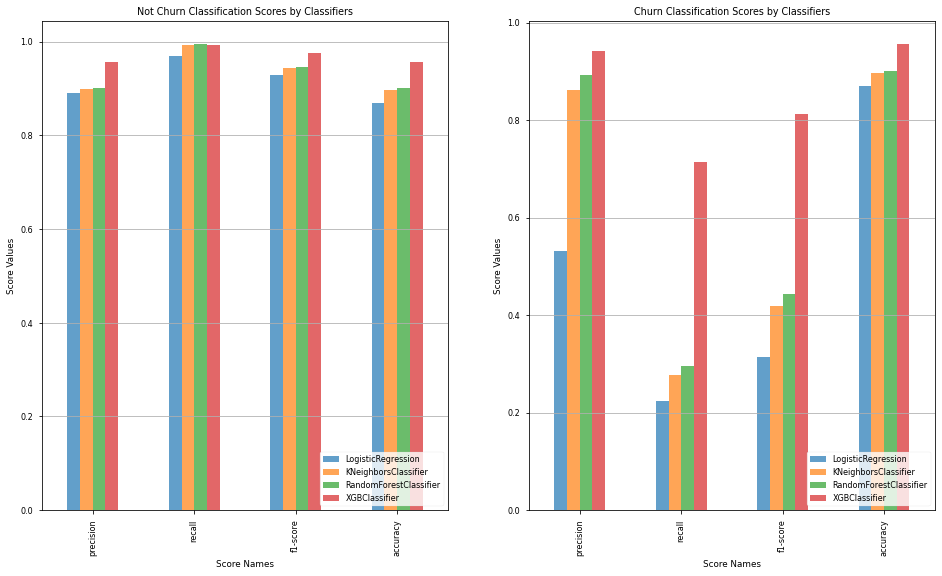

In [148]:
# Comparison scores plot for the models
plot_clf_rpt([df_not_churn, df_churn], ['Not Churn', 'Churn'])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>Across the 4 scores, logistic regression classifier fared the worst.  XGBoosts came out on top among the 4 classifiers.</li>
            <li>All models reported an impressive accuracy score of over 90%.</li>
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>Logistic regression's performance pale compared to the other three classifiers.  Again, XGBoost came out on top as the best model.</li>
            <li>Recall and f1_score values were low which might be caused by the class imbalance issue.</li>
        </ul>
</div>

### Plot Confusion Matrix

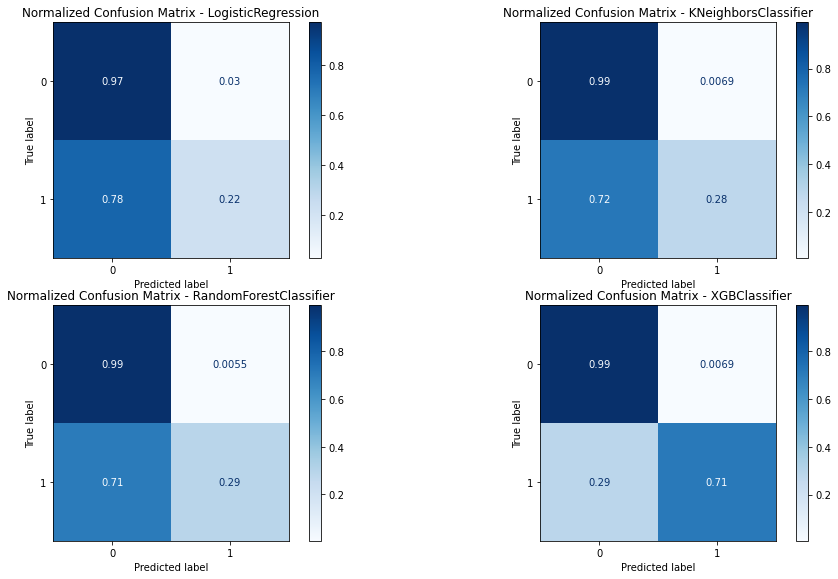

In [149]:
# Plot the confusion Matrix
plot_conf_mat(classifiers, X_test_ohe, y_test)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>All 4 classifiers did very well in predicting the "Not Churn" label.</li>
        <li>XGBoost did well with predicting the 'churn' label, at 71% of the time.  The other three did poorly with less than 30% of the time, worse than random guessing.</li>
        <li>In addition, XGBoost reported the lowest false negative by a big margin compared to the other three classifiers.</li>
        <li>As for false positive, all models show similar performances.</li>
    </ul>
</div>

***
## Fine Tune Models

### Address Class Imbalance Problems

In [150]:
# Use SMOTE since we don't have a lot of features and data, computational issues are mininum
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train_ohe, y_train)

# Check new train dataset
print(pd.Series(y_train_smote.value_counts()))


1    2128
0    2128
Name: churn, dtype: int64


### Fit Model with Resample Data

In [151]:
# Create dataframe to store classification report details
clf_dict = {}
for clf in classifiers:
     clf_dict[type(clf).__name__] =  fit_model(clf, X_train_smote, y_train_smote, X_test_ohe, y_test)

df_clf_rpt = pd.concat(clf_dict.values(), axis=1, keys=clf_dict.keys())
df_clf_rpt.head()

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.957895  0.756233  0.845201  722.000000   
Churn                  0.333333  0.785714  0.468085  112.000000   
accuracy               0.760192  0.760192  0.760192    0.760192   
macro avg              0.645614  0.770973  0.656643  834.000000   
weighted avg           0.874021  0.760192  0.794557  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.948675  0.793629  0.864253  722.000000   
Churn                    0.352174  0.723214  0.473684  112.000000   
accuracy                 0.784173  0.784173  0.784173    0.784173   
macro avg                0.650425  0.758422  0.668969  834.000000   
weighted avg             0.868570  0.784173  0.811803  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.957164  0.897507  0.926376  722.000000   
Churn                      0.528662  0.741071  0.617100  112.000000   
accuracy                   0.876499  0.876499  0.876499    0.876499   
macro avg                  0.742913  0.819289  0.771738  834.000000   
weighted avg               0.899619  0.876499  0.884843  834.000000   

             XGBClassifier                                  
                 precision    recall  f1-score     support  
Not Churn         0.963939  0.962604  0.963271  722.000000  
Churn             0.761062  0.767857  0.764444  112.000000  
accuracy          0.936451  0.936451  0.936451    0.936451  
macro avg         0.862500  0.865231  0.863858  834.000000  
weighted avg      0.936694  0.936451  0.936570  834.000000

### Plot Comparison Classification Report Scores

In [152]:
# Create trimed down version classification report for not churn
col_names = ['precision', 'recall', 'f1-score']
df_nc_smote = clf_rpt_by_label(df_clf_rpt, clf_dict, col_names, 0)
print('Not Churn Classification Report Afteer Resampling with Smote')
display(df_nc_smote)

# Create trimed down version classification report for churn
df_c_smote = clf_rpt_by_label(df_clf_rpt, clf_dict, col_names, 1)
print('\nChurn Classification Report After Resampling with Smote')
display(df_c_smote)

Not Churn Classification Report


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
precision,0.957895,0.948675,0.957164,0.963939
recall,0.756233,0.793629,0.897507,0.962604
f1-score,0.845201,0.864253,0.926376,0.963271
accuracy,0.760192,0.784173,0.876499,0.936451



Churn Classification Report


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
precision,0.333333,0.352174,0.528662,0.761062
recall,0.785714,0.723214,0.741071,0.767857
f1-score,0.468085,0.473684,0.617100,0.764444
accuracy,0.760192,0.784173,0.876499,0.936451



***** Performance Gain/Loss after SMOTE *****



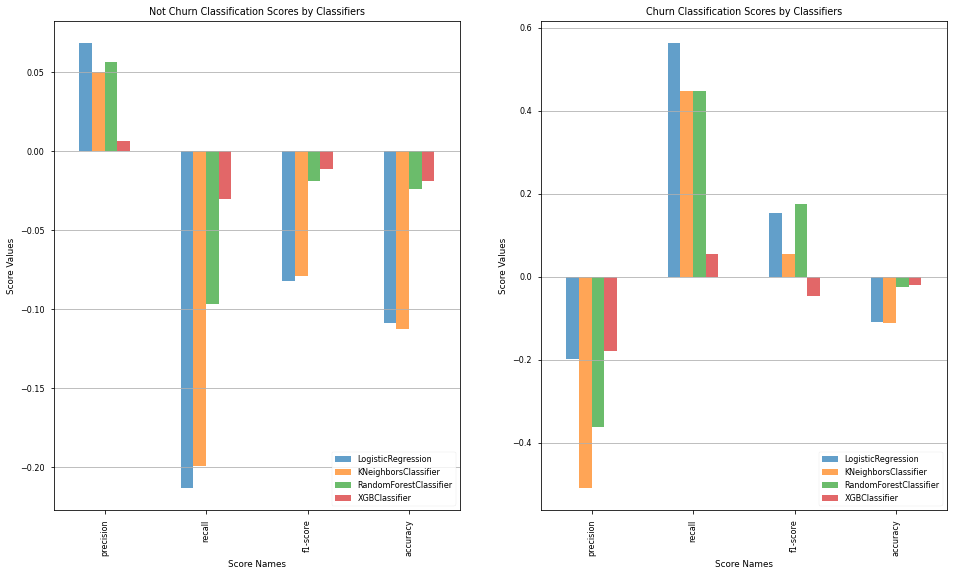

In [153]:
# plot performance changes after resampling with SMOTE
df_nc_diff = df_nc_smote.subtract(df_not_churn, axis='columns')
df_c_diff = df_c_smote.subtract(df_churn, axis='columns')

print('\n***** Performance Gain/Loss after SMOTE *****\n')
plot_clf_rpt([df_nc_diff, df_c_diff], ['Not Churn', 'Churn'])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>After resampling the training data with SMOTE, all four models reported improvements in the precision scores.  However, recall, f1_score and accuracy seem to have taken a downward fall, especially the recall score.</li>            
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>We saw a mixed performances here.  Precision dropped greatly for all four models but  improved significantly in the recall score which make sense since precision and recall are inversely related.</li>
        </ul>
</div>

### Grid Search Hyperparameters 

In [154]:
# Establish GridSearch parameter grids for the models

# fit_intercept, add bias if true.  Small C = stronger regularization
# Since sample data are quite small and doesn't involve multi class, set solver to liblinear
# liblinear only works with penalty 'l1', omit 'l2' from parameter
lr_params = {'fit_intercept': [True, False],
             'C': [0.001,0.01,0.1,1,10,100,1000],
             'penalty': ['l1'],
             'solver': ['liblinear']}

# A lower n_neighbors = more complex model.  Distance in weight means closer neighbors
# of a query point will have a greater influnce.
knn_params = {'n_neighbors': list(range(1, 33, 2)),
              'metric': ['euclidean', 'minkowski'],
              'weights': ['uniform', 'distance']}

# n_estimators = number of trees in the foreset; max_features = max number of features
# considered for splitting a node; max_dept = max number of levels in each decision tree
# min_samples_leaf = min number of data points allowed in a leaf node
rf_params = {'n_estimators': [5, 30, 100, 170, 250],
             'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth' : [4,5,6,7,8],
             'min_samples_leaf': [3, 5, 7]}

# min_child_weight = min_sample_leaf; 
xg_params = {'n_estimators': [5, 30, 100, 170, 250],
             'max_depth': range(3,10,2),
             'min_child_weight': list(range(1,6,2)),
             'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

# Set up functions parameters
alg_dict = {'lr': LogisticRegression(max_iter=10000), 'knn': KNeighborsClassifier(),
            'rf': RandomForestClassifier(), 'xg': xgb.XGBClassifier()}

mdl_params = {'lr_grd_sch': lr_params, 'knn_grd_sch': knn_params,
              'rf_grd_sch': rf_params , 'xg_grd_sch': xg_params}

In [155]:
# !!!!! This cell takes about 20 mins to run !!!!!
# Run GridSearch and store results in a dataframe
df_tuned_mdl = fit_tuned_model(alg_dict, mdl_params, X_train_smote, y_train_smote)

In [156]:
# View results
df_tuned_mdl.head()

,no_model,exec_time,best_params,best_est,best_score
lr,14,00:00:05,"{'C': 100, 'fit_intercept': False, 'penalty': ...","LogisticRegression(C=100, fit_intercept=False,...",0.838367
knn,64,00:00:39,"{'metric': 'euclidean', 'n_neighbors': 9, 'wei...","KNeighborsClassifier(metric='euclidean', n_nei...",0.982486
rf,225,00:05:16,"{'max_depth': 8, 'max_features': 'sqrt', 'min_...","(DecisionTreeClassifier(max_depth=8, max_featu...",0.981194
xg,360,00:14:47,"{'learning_rate': 0.2, 'max_depth': 9, 'min_ch...","XGBClassifier(learning_rate=0.2, max_depth=9, ...",0.993587


In [157]:
# View best estimators
print(df_tuned_mdl.best_est.values)

[LogisticRegression(C=100, fit_intercept=False, max_iter=10000, penalty='l1',
                   solver='liblinear')
 KNeighborsClassifier(metric='euclidean', n_neighbors=9, weights='distance')
 RandomForestClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=3,
                       n_estimators=170)
 XGBClassifier(learning_rate=0.2, max_depth=9, n_estimators=250)]


### Fit Tuned Models

In [158]:
# Create dataframe to store classification report details for tuned models
tuned_classifiers = df_tuned_mdl.best_est
clf_tuned_dict = {}

for clf in tuned_classifiers:
     clf_tuned_dict[type(clf).__name__] =  fit_model(clf, X_train_smote, y_train_smote,
                                                          X_test_ohe, y_test)

df_tuned_clf_rpt = pd.concat(clf_tuned_dict.values(), axis=1, keys=clf_tuned_dict.keys())
df_tuned_clf_rpt.head()

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.957895  0.756233  0.845201  722.000000   
Churn                  0.333333  0.785714  0.468085  112.000000   
accuracy               0.760192  0.760192  0.760192    0.760192   
macro avg              0.645614  0.770973  0.656643  834.000000   
weighted avg           0.874021  0.760192  0.794557  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.949580  0.782548  0.858011  722.000000   
Churn                    0.343096  0.732143  0.467236  112.000000   
accuracy                 0.775779  0.775779  0.775779    0.775779   
macro avg                0.646338  0.757346  0.662624  834.000000   
weighted avg             0.868134  0.775779  0.805533  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.959834  0.959834  0.959834  722.000000   
Churn                      0.741071  0.741071  0.741071  112.000000   
accuracy                   0.930456  0.930456  0.930456    0.930456   
macro avg                  0.850453  0.850453  0.850453  834.000000   
weighted avg               0.930456  0.930456  0.930456  834.000000   

             XGBClassifier                                  
                 precision    recall  f1-score     support  
Not Churn         0.966033  0.984765  0.975309  722.000000  
Churn             0.887755  0.776786  0.828571  112.000000  
accuracy          0.956835  0.956835  0.956835    0.956835  
macro avg         0.926894  0.880775  0.901940  834.000000  
weighted avg      0.955521  0.956835  0.955603  834.000000

### Plot Classification Report Scores

In [159]:
# Create trimed down version of classification report for not churn
col_names = ['precision', 'recall', 'f1-score']
df_tuned_not_churn = clf_rpt_by_label(df_tuned_clf_rpt, clf_tuned_dict,
                                      col_names, 0)
print('***** Not Churn Classification Report on Test Data*****')
display(df_tuned_not_churn)

# Create trimed down version of classification report for churn
df_tuned_churn = clf_rpt_by_label(df_tuned_clf_rpt, clf_tuned_dict,
                                  col_names, 1)
print('\n***** Churn Classification Report on Test Data*****')
display(df_tuned_churn)

***** Not Churn Classification Report *****


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
precision,0.957895,0.949580,0.959834,0.966033
recall,0.756233,0.782548,0.959834,0.984765
f1-score,0.845201,0.858011,0.959834,0.975309
accuracy,0.760192,0.775779,0.930456,0.956835



***** Churn Classification Report *****


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
precision,0.333333,0.343096,0.741071,0.887755
recall,0.785714,0.732143,0.741071,0.776786
f1-score,0.468085,0.467236,0.741071,0.828571
accuracy,0.760192,0.775779,0.930456,0.956835


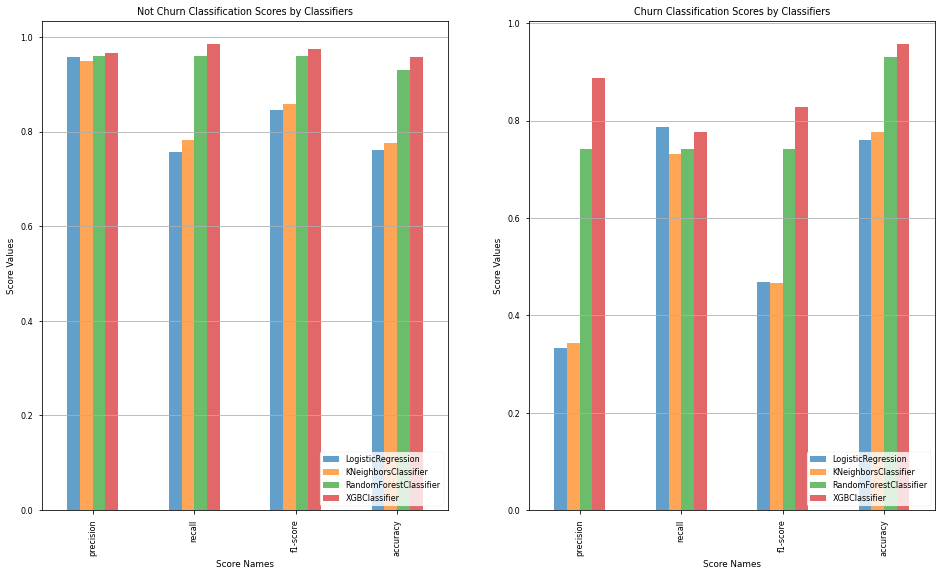

In [160]:
# Comparison scores plot for the models
plot_clf_rpt([df_tuned_not_churn, df_tuned_churn], ['Not Churn', 'Churn'])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>All four tuned models performance were on par with each other in the precision area.</li>
            <li>Both random forest and XGBoost models produced remarkable scores, with XGBoost edged out slightly over the random forest model.</li>
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>XGBoost came out on top of the chart across all four scores.</li>
            <li>Logistic regression model did very well in the recall score.  Unfortunately, it performed poorly in the recall score of the "Not Churn" prediction.  Furthermore, we are more concerned with the recall scores produced by our final model, we should dismiss the logistic regression model, if this were our final tuning.</li>
        </ul>
</div>

### Plot Confusion Matrix

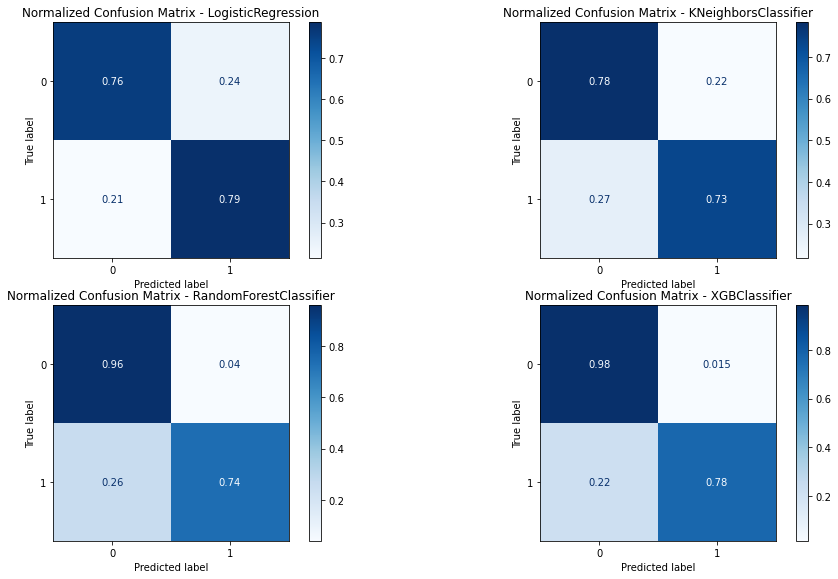

In [161]:
plot_conf_mat(tuned_classifiers, X_test_ohe, y_test)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>These plots confirmed the findings in the classification report plots.</li>
        <li>Random forest and XGBoost classifiers should be considered for our final model, based on the recall scores performance.</li>
    </ul>
</div>

### Plot Comparison Classification Report Scores


***** Performance Gain/Loss Tuned vs Base Model *****



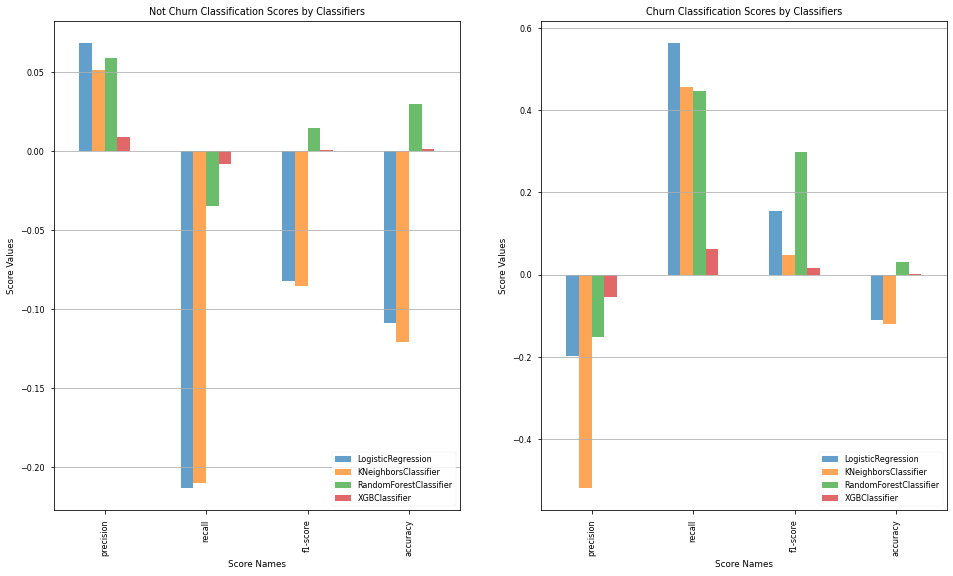

In [162]:
# plot performance changes after tuning models (tuned vs base)
df_nc_t_unt = df_tuned_not_churn.subtract(df_not_churn, axis='columns')
df_c_t_unt = df_tuned_churn.subtract(df_churn, axis='columns')

print('\n***** Performance Gain/Loss Tuned vs Base Model *****\n')
plot_clf_rpt([df_nc_t_unt, df_c_t_unt], ['Not Churn', 'Churn'])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>Gains in the precision department by the tuned models led to a loss in the recall scores.</li>
            <li>Grid search did not help logistic regression and KNN models as we see a decrease in f1_score and accuracy scores.</li>
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>Random forest benefits the most from the hyperparameters tuning.</li>
            <li>XGBoost did not improve much from tuning.  Perhaps, new parameters should be included in the next round of tunings.</li>
        </ul>
    <p>--- Conclusion ---</p>
        <ul>
            <li>Although XGBoost did not improve much from fine tuning, it still led the pack in the model outcomes.  We will use XGBoost classifier as our model of choice.</li>
        </ul>
</div>

***
## Fine Tune Model Round II

As we have narrowed down our models of choice, it will be worth while to further fine tune the classifier.

### Grid Search Hyperparameters

In [163]:
# In round I of tuning, the best estimators for XGBoost are learning_rate=01.,
# max_depth=9, n_estimators=250

# Introduce additional parameters
xg_params = {'n_estimators': [5, 30, 100, 170, 250],
             'max_depth': range(3,10,2),
             'min_child_weight': list(range(1,6,2)),
             'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
             # additional params 
             'subssample': [0.8, 0.9, 1],
             'colsample_bytree': [0.8, 0.9, 1],
             'objective': ['reg:squarederror', 'binary:logistic']}

# Set up functions parameters
alg_dict = {'xg': xgb.XGBClassifier()}

mdl_params = {'xg_grd_sch': xg_params}

In [164]:
# !!!!! This step will take about 3 hrs to run !!!!!
# Run GridSearch and store results in a dataframe
df_tuned_xg = fit_tuned_model(alg_dict, mdl_params, X_train_smote, y_train_smote)

In [165]:
# View results
df_tuned_xg.head()

,no_model,exec_time,best_params,best_est,best_score
xg,6480,02:47:56,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...","XGBClassifier(colsample_bytree=0.9, max_depth=...",0.993727


In [166]:
# View best estimator
df_tuned_xg.best_est.values

array([XGBClassifier(colsample_bytree=0.9, max_depth=9, n_estimators=170,
              subssample=0.8)], dtype=object)

### Fit Tuned Model II

In [167]:
# Create dataframe to store classification report details
df_tuned_xg_rpt = fit_model(df_tuned_xg.best_est.values[0], X_train_smote,
                            y_train_smote, X_test_ohe, y_test)
df_tuned_xg_rpt.head()

,precision,recall,f1-score,support
Not Churn,0.963315,0.981994,0.972565,722.000000
Churn,0.867347,0.758929,0.809524,112.000000
accuracy,0.952038,0.952038,0.952038,0.952038
macro avg,0.915331,0.870462,0.891044,834.000000
weighted avg,0.950427,0.952038,0.950670,834.000000


### Compare Tuned I & II XGBoost


***** Performance Gain/Loss Tuned XGBoost II VS I *****



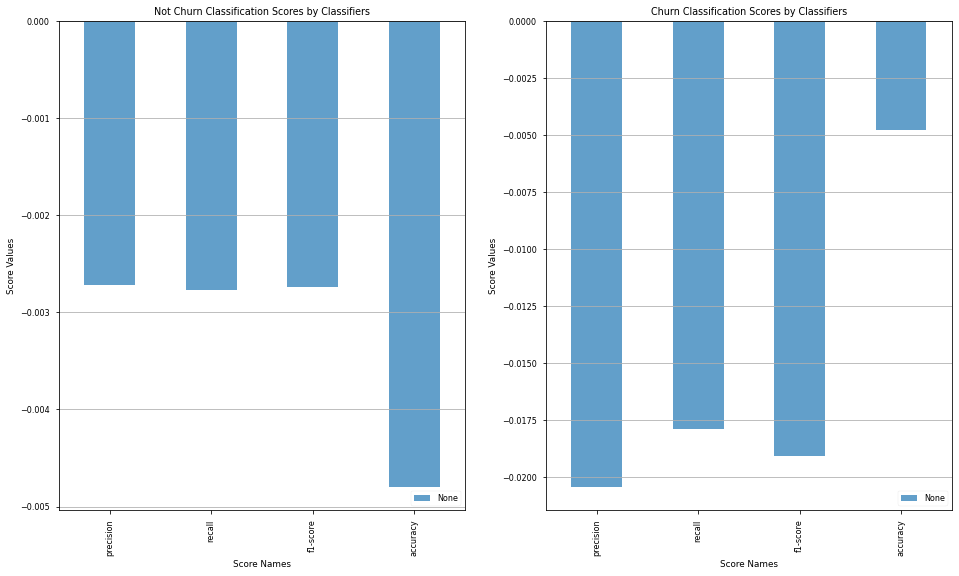

In [172]:
# Create pandas series
nc_tuned_1 = df_tuned_not_churn.XGBClassifier
c_tuned_1 = df_tuned_churn.XGBClassifier
nc_tuned_2 = df_tuned_xg_rpt.loc['Not Churn']
c_tuned_2 = df_tuned_xg_rpt.loc['Churn']

# Append accuracy scores
nc_tuned_2.support = df_tuned_xg_rpt.loc['accuracy', 'precision']
c_tuned_2.support = df_tuned_xg_rpt.loc['accuracy', 'precision']

# Rename labels
nc_tuned_2.rename({'support': 'accuracy'}, inplace=True)
c_tuned_2.rename({'support': 'accuracy'}, inplace=True)

# # Check results
# print((nc_tuned_2 - nc_tuned_1))
# print('\n')
# print(c_tuned_2 - c_tuned_1)

# Plot performance gain/loss
print('\n***** Performance Gain/Loss Tuned XGBoost II VS I *****\n')
plot_clf_rpt([(nc_tuned_2 - nc_tuned_1), (c_tuned_2 - c_tuned_1)],
             ['Not Churn', 'Churn'])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>In round II of tuning we added 3 more parameters: 
            'subssample': [0.8, 0.9, 1],
            'colsample_bytree': [0.8, 0.9, 1],
            'objective': ['reg:squarederror', 'binary:logistic']}
        This increases the number of models to be trained from 360 to 6480 models.  Time taken to train the model jumps from 16mins to 2hrs 52mins.</li>
        <li>The Tuned model II shows decrease in all four scores for both labels.</li>
    </ul>
</div>

***
## Model Evaluation

### Model Validation

In [173]:
# Instantiate the object
xg_clf = xgb.XGBClassifier(learning_rate=0.2, max_depth=9, n_estimators=250)

# Fit the model
xg_clf.fit(X_train_smote, y_train_smote)

XGBClassifier(learning_rate=0.2, max_depth=9, n_estimators=250)

In [174]:
# Predit
y_train_pred = xg_clf.predict(X_train_smote)
y_test_pred = xg_clf.predict(X_test_ohe)

# Get accuracy scores
y_train_acc = accuracy_score(y_train_smote, y_train_pred)
y_test_acc = accuracy_score(y_test, y_test_pred)

print(f'\n***** Train Accuracy: {y_train_acc * 100}%. ' +
      f'Test Accuracy:{round(y_test_acc * 100,2)}% *****')


***** Train Accuracy: 100.0%. Test Accuracy:95.68% *****


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Both accuracy scores from train and test set are very close, which indicates that the model is not overfitting.</li>
    </ul>
</div>

### Model ROC Curve


***** AUC Score: 87.87% *****


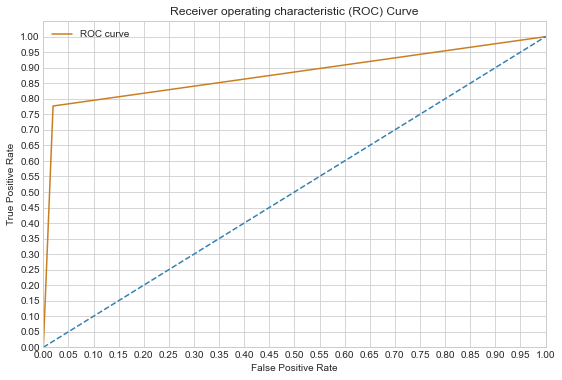

In [56]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(f'\n***** AUC Score: {round(roc_auc_score(y_test, y_test_pred)*100,2)}% *****')

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,6))
    plt.plot(fpr, tpr, label="ROC curve", color='#C87F21')
    plt.plot([0,1],[0,1], color='#3380B2', linestyle='--')
    plt.xlim([0.0, 1.0], )
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend()
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Our model produces a Area under the Curve (AUC) score of 0.8787.  In other words, the model correctly distinguished between 'Churn' and 'Not Churn' at approximately 88% of the time.</li>
        <li>The conclusion established above is also evidenced by the ROC curve hugging the upper left corner of the plot.</li>
    </ul>
</div>

***
## Alternate Model (Model B)

The sample data includes the States where the customers reside.  Perhaps, the geographic data might provide additional insights as to why and where the churn happen.  Here we will construct another model without grouping the States by Region.  It will be referred as model B.

### Explore Data

In [182]:
# Create a new daaframe without the States grouping
df_alt = df.copy()

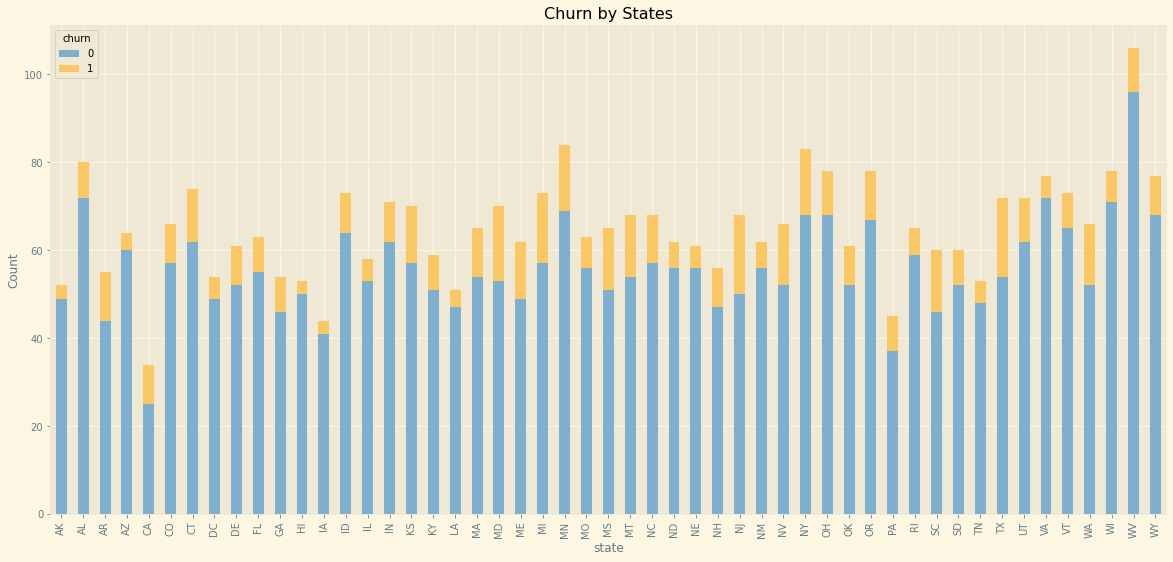

In [183]:
# Plot the churn rate by States
with plt.style.context('Solarize_Light2'):
    fig, axes = plt.subplots(figsize=(20,9))
    df_alt.groupby(['state', 'churn']).size().unstack().plot(kind='bar',
                                                             stacked=True,
                                                             color=['#7FAFCE','#F9C764'],
                                                             ax=axes)
    plt.ylabel('Count')
    plt.title('Churn by States')
    plt.show()

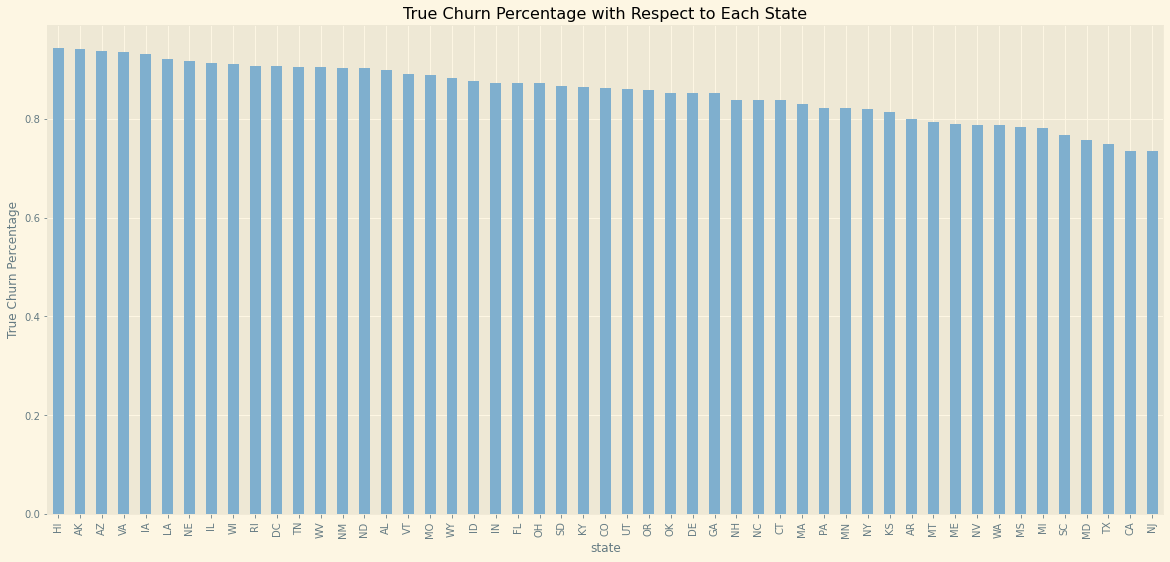

In [184]:
# Plot the true churn rate percentage per State
state_true_c = (df_alt.groupby('state')['churn'].
                value_counts(normalize=True).unstack()[0].sort_values(ascending=False))

with plt.style.context('Solarize_Light2'):
    fig, axes = plt.subplots(figsize=(20,9))
    state_true_c.plot(kind='bar', stacked=True, color='#7FAFCE', ax=axes)
    plt.ylabel('True Churn Percentage')
    plt.title('True Churn Percentage with Respect to Each State')
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The top 5 Sates with the highest Churn rates are HI, AK, AZ, VA and IA.</li>
    </ul>
</div>

***
## Model B - Premodeling Preparations

### Create Train Test Split

In [185]:
# Separate labels and features
y_a = df_alt.churn.copy()
X_a = df_alt.drop(columns='churn', axis=1).copy()


X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_a,
                                                            y_a,
                                                            test_size=0.25,
                                                            random_state=36 )
print(X_a_train.shape, X_a_test.shape)

(2499, 19) (834, 19)


### Set Up Pipeline

In [186]:
# Create a separate pipeline in case we need to rerun the pipeline for 
# model A.

# Create categorical and numerical columns
cat_col_a = X_a_train.select_dtypes(object).columns
num_col_a = X_a_train.select_dtypes('number').columns

# Check variables
print(cat_col_a)
print('\n')
print(num_col_a)

Index(['state', 'international plan', 'voice mail plan'], dtype='object')


Index(['account length', 'area code', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls'],
      dtype='object')


In [187]:
# Setup Pipeline
cat_trans_a = Pipeline(steps=[('encoder', OneHotEncoder(sparse=False,
                                                      handle_unknown='ignore'))])
num_trans_a = Pipeline(steps=[('scaler', StandardScaler())])

# Combine both pipelines with ColumnTransformer
preprocessing_a = ColumnTransformer(transformers=[
                                 ('cat', cat_trans_a, cat_col_a),
                                 ('num', num_trans_a, num_col_a)])

# Visualize transformer
set_config(display='diagram')
preprocessing_a

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['state', 'international plan', 'voice mail plan'], dtype='object')),
                                ('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['account length', 'area code', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls'],
      dtype='object'))])

### Transform Data

In [188]:
# Transform Column Features
X_a_train_t = preprocessing_a.fit_transform(X_a_train)
X_a_test_t = preprocessing_a.transform(X_a_test)
X_a_train_t[0:3]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.95421778,  1.74620312, -0.59255668, -1.16732592,  0.03493391,
        -1.16706024,  0.02320902, -0.06025108,  0.02248751, -0.36626746,
         0.13848135, -0.36432383,  0.4896763 ,  0.2

### Convert Transformed Data to Dataframe

In [189]:
# Get column feature names
enc_a = preprocessing_a.named_transformers_['cat'].named_steps['encoder']
cat_features_a = enc_a.get_feature_names(cat_col_a)
cat_features_a

array(['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL',
       'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA',
       'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE',
       'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV',
       'state_WY', 'international plan_no', 'international plan_yes',
       'voice mail plan_no', 'voice mail plan_yes'], dtype=object)

In [194]:
# Create new dataframe from transformed data
X_a_train_ohe = pd.DataFrame(X_a_train_t, columns=[*cat_features_a, *num_col_a])
display(X_a_train_ohe.head())

X_a_test_ohe = pd.DataFrame(X_a_test_t, columns=[*cat_features_a, *num_col_a])
X_a_test_ohe.head()

,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,...,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023209,-0.060251,0.022488,-0.366267,0.138481,-0.364324,0.489676,0.200580,0.486266,-1.176545
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.772582,0.090719,-0.771814,-0.055284,-0.014060,-0.053780,0.454189,0.200580,0.459980,1.846005
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.297921,0.946216,-1.298297,-0.456807,-0.319142,-0.456175,0.241267,-0.608539,0.236548,1.846005
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.192485,-0.865425,0.191878,-0.391855,-0.420836,-0.390567,0.276754,3.437053,0.275978,-1.176545
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.583849,-0.009928,-0.584112,-1.242140,-1.336083,-1.243470,-1.710523,1.818816,-1.708622,-0.420907


,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,...,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-1.685115,2.153976,-1.685147,-1.057124,-1.081847,-1.055394,1.376853,-0.608539,1.379993,2.601643
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.550772,-1.368658,-0.549776,-0.169442,-0.675071,-0.167500,0.383215,-1.013098,0.381122,-0.420907
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.074076,0.543629,-0.073653,0.234050,-0.115754,0.234895,0.418702,-0.608539,0.420551,0.334730
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.019407,0.191366,1.020515,0.141542,-1.386930,0.143044,0.170293,0.200580,0.170833,0.334730
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.148013,-2.324802,-0.146903,0.436780,-0.319142,0.436093,1.021983,0.200580,1.025131,-0.420907


***
## Alternate Model - Baseline Classification Models

In [195]:
# Fitting base models to various logistic algorithms
# Define list of classifiers
classifiers_a = [LogisticRegression(), KNeighborsClassifier(), 
               RandomForestClassifier(max_depth=5), xgb.XGBClassifier()]     

# Create dataframe to store classification report details
clf_dict_a = {}
for clf in classifiers_a:
     clf_dict_a[type(clf).__name__] =  fit_model(clf, X_a_train_ohe,
                                               y_a_train, X_a_test_ohe, y_a_test)

df_clf_rpt_a = pd.concat(clf_dict_a.values(), axis=1, keys=clf_dict_a.keys())
df_clf_rpt_a.head()

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.889885  0.969317  0.927904  717.000000   
Churn                  0.584906  0.264957  0.364706  117.000000   
accuracy               0.870504  0.870504  0.870504    0.870504   
macro avg              0.737395  0.617137  0.646305  834.000000   
weighted avg           0.847100  0.870504  0.848894  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.887359  0.988842  0.935356  717.000000   
Churn                    0.771429  0.230769  0.355263  117.000000   
accuracy                 0.882494  0.882494  0.882494    0.882494   
macro avg                0.829394  0.609806  0.645310  834.000000   
weighted avg             0.871096  0.882494  0.853976  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.881919  1.000000  0.937255  717.000000   
Churn                      1.000000  0.179487  0.304348  117.000000   
accuracy                   0.884892  0.884892  0.884892    0.884892   
macro avg                  0.940959  0.589744  0.620801  834.000000   
weighted avg               0.898484  0.884892  0.848466  834.000000   

             XGBClassifier                                 
                 precision    recall  f1-score    support  
Not Churn         0.967302  0.990237  0.978635  717.00000  
Churn             0.930000  0.794872  0.857143  117.00000  
accuracy          0.962830  0.962830  0.962830    0.96283  
macro avg         0.948651  0.892554  0.917889  834.00000  
weighted avg      0.962069  0.962830  0.961592  834.00000

### Plot Classification Report Scores

In [196]:
# Create trimed down version classification report for not churn
col_names = ['precision', 'recall', 'f1-score']
df_not_churn_a = clf_rpt_by_label(df_clf_rpt_a, clf_dict_a, col_names, 0)
print('***** Not Churn Classification Report *****')
display(df_not_churn)

# Create trimed down version classification report for churn
df_churn_a = clf_rpt_by_label(df_clf_rpt_a, clf_dict_a, col_names, 1)
print('\n***** Churn Classification Report *****')
display(df_churn)

***** Not Churn Classification Report *****


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
precision,0.889454,0.898496,0.900878,0.957276
recall,0.969529,0.993075,0.994460,0.993075
f1-score,0.927767,0.943421,0.945359,0.974847
accuracy,0.869305,0.896882,0.900480,0.955635



***** Churn Classification Report *****


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
precision,0.531915,0.861111,0.891892,0.941176
recall,0.223214,0.276786,0.294643,0.714286
f1-score,0.314465,0.418919,0.442953,0.812183
accuracy,0.869305,0.896882,0.900480,0.955635


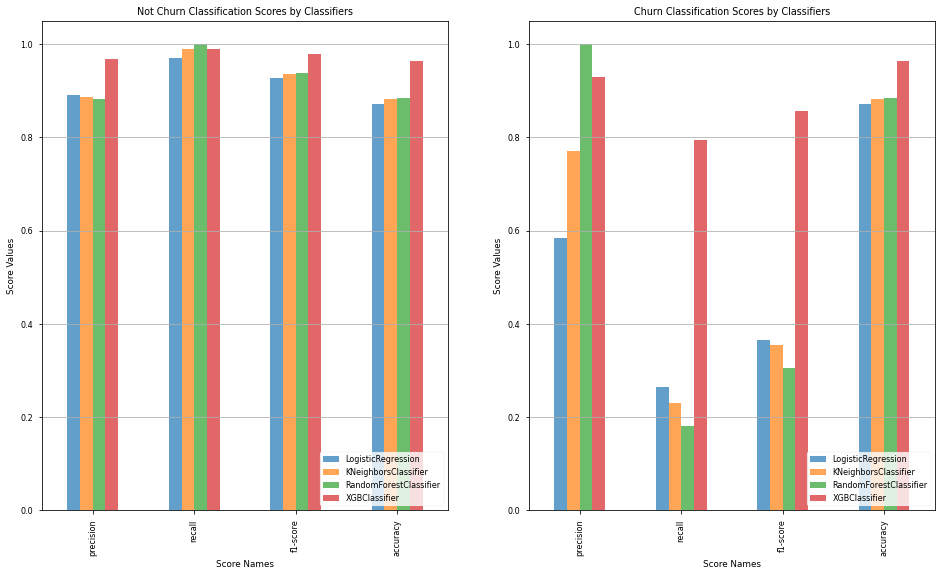

In [197]:
# Comparison scores plot for the models
plot_clf_rpt([df_not_churn_a, df_churn_a], ['Not Churn', 'Churn'])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>Across the 4 scores, logistic regression had the lowest performance.  XGBoosts led with 3 out of the 4 scores.</li>
            <li>All models reported an impressive accuracy score of over 90%.</li>
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>XGBoost came out on top as the best model.</li>
            <li>Recall and f1_score values were low which might be caused by the class imbalance issue.</li>
        </ul>
</div>

### Plot Confusion Matrix

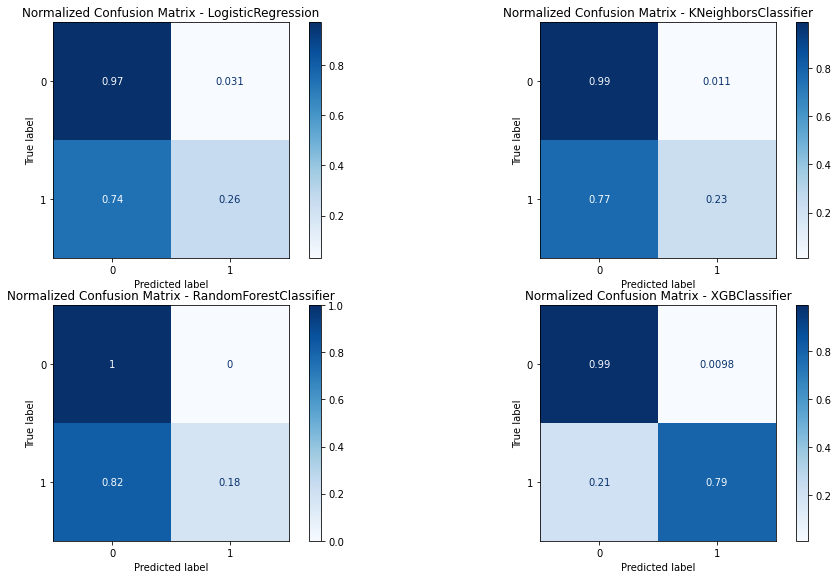

In [198]:
# Plot the confusion Matrix
plot_conf_mat(classifiers_a, X_a_test_ohe, y_a_test)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>All 4 classifiers did very well in predicting the "Not Churn" label.</li>
        <li>XGBoost did well with predicting the 'churn' label, at 79% of the time.  The other three did poorly with less than 30% of the time, worse than random guessing.</li>
        <li>In additional, XGBoost reported the lowest false negative by a big margin compared to the other three classifiers.</li>
        <li>As for false positive, logistic regression classifier came in last.</li>
    </ul>
</div>

***
## Alternate Model - Fine Tune Models

### Address Class Imbalance Problems

In [199]:
# Use SMOTE since we don't have a lot of features and data, computational issues are mininum
smote = SMOTE()
X_a_train_smote, y_a_train_smote = smote.fit_sample(X_a_train_ohe,
                                                    y_a_train)

# Check new train dataset
print(pd.Series(y_a_train_smote.value_counts()))

1    2133
0    2133
Name: churn, dtype: int64


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Since we already saw how SMOTE improved model performances, we will skip the validation here.</li>
    </ul>
</div>

### Grid Search Hyperparameters

In [200]:
# Establish GridSearch parameter grids for the models

# fit_intercept, add bias if true.  Small C = stronger regularization
# Since sample data are quite small and doesn't involve multi class, set solver to liblinear
# liblinear only works with penalty 'l1', omit 'l2' from parameter
lr_params = {'fit_intercept': [True, False],
             'C': [0.001,0.01,0.1,1,10,100,1000],
             'penalty': ['l1'],
             'solver': ['liblinear']}

# A lower n_neighbors = more complex model.  Distance in weight means closer neighbors
# of a query point will have a greater influnce.
knn_params = {'n_neighbors': list(range(1, 33, 2)),
              'metric': ['euclidean', 'minkowski'],
              'weights': ['uniform', 'distance']}

# n_estimators = number of trees in the foreset; max_features = max number of features
# considered for splitting a node; max_dept = max number of levels in each decision tree
# min_samples_leaf = min number of data points allowed in a leaf node
rf_params = {'n_estimators': [5, 30, 100, 170, 250],
             'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth' : [4,5,6,7,8],
             'min_samples_leaf': [3, 5, 7]}

# min_child_weight = min_sample_leaf; 
xg_params = {'n_estimators': [5, 30, 100, 170, 250],
             'max_depth': range(3,10,2),
             'min_child_weight': list(range(1,6,2)),
             'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

# Set up functions parameters
alg_dict = {'lr': LogisticRegression(max_iter=10000), 'knn': KNeighborsClassifier(),
            'rf': RandomForestClassifier(), 'xg': xgb.XGBClassifier()}

mdl_params = {'lr_grd_sch': lr_params, 'knn_grd_sch': knn_params,
              'rf_grd_sch': rf_params , 'xg_grd_sch': xg_params}

In [201]:
# !!!!! This cell takes about 25 mins to run !!!!!
# Run GridSearch and store results in a dataframe
df_tuned_mdl_a = fit_tuned_model(alg_dict, mdl_params, X_a_train_smote, y_a_train_smote)

In [202]:
# View results
df_tuned_mdl_a.head()

,no_model,exec_time,best_params,best_est,best_score
lr,14,00:00:17,"{'C': 1, 'fit_intercept': False, 'penalty': 'l...","LogisticRegression(C=1, fit_intercept=False, m...",0.844251
knn,64,00:01:36,"{'metric': 'euclidean', 'n_neighbors': 9, 'wei...","KNeighborsClassifier(metric='euclidean', n_nei...",0.982605
rf,225,00:05:59,"{'max_depth': 8, 'max_features': 'sqrt', 'min_...","(DecisionTreeClassifier(max_depth=8, max_featu...",0.973880
xg,360,00:23:44,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...","XGBClassifier(max_depth=7, n_estimators=250)",0.992943


In [203]:
# View best estimators
print(df_tuned_mdl_a.best_est.values)

[LogisticRegression(C=1, fit_intercept=False, max_iter=10000, penalty='l1',
                   solver='liblinear')
 KNeighborsClassifier(metric='euclidean', n_neighbors=9, weights='distance')
 RandomForestClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=3,
                       n_estimators=250)
 XGBClassifier(max_depth=7, n_estimators=250)]


### Fit Tuned Models

In [204]:
# Create dataframe to store classification report details for tuned models
tuned_classifiers_a = df_tuned_mdl_a.best_est
clf_tuned_dict_a = {}

for clf in tuned_classifiers_a:
     clf_tuned_dict_a[type(clf).__name__] =  fit_model(clf, X_a_train_smote, y_a_train_smote,
                                                          X_a_test_ohe, y_a_test)

df_tuned_clf_rpt_a = pd.concat(clf_tuned_dict_a.values(), axis=1, keys=clf_tuned_dict_a.keys())
df_tuned_clf_rpt_a.head()

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.956522  0.767085  0.851393  717.000000   
Churn                  0.355212  0.786325  0.489362  117.000000   
accuracy               0.769784  0.769784  0.769784    0.769784   
macro avg              0.655867  0.776705  0.670377  834.000000   
weighted avg           0.872165  0.769784  0.800605  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.948307  0.741980  0.832551  717.000000   
Churn                    0.322344  0.752137  0.451282  117.000000   
accuracy                 0.743405  0.743405  0.743405    0.743405   
macro avg                0.635325  0.747059  0.641916  834.000000   
weighted avg             0.860492  0.743405  0.779064  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.966954  0.938633  0.952583  717.000000   
Churn                      0.681159  0.803419  0.737255  117.000000   
accuracy                   0.919664  0.919664  0.919664    0.919664   
macro avg                  0.824057  0.871026  0.844919  834.000000   
weighted avg               0.926861  0.919664  0.922375  834.000000   

             XGBClassifier                                  
                 precision    recall  f1-score     support  
Not Churn         0.976422  0.981869  0.979138  717.000000  
Churn             0.884956  0.854701  0.869565  117.000000  
accuracy          0.964029  0.964029  0.964029    0.964029  
macro avg         0.930689  0.918285  0.924351  834.000000  
weighted avg      0.963590  0.964029  0.963766  834.000000

### Plot Classification Report Scores

In [205]:
# Create trimed down version of classification report for not churn
col_names = ['precision', 'recall', 'f1-score']
df_tuned_not_churn_a = clf_rpt_by_label(df_tuned_clf_rpt_a, clf_tuned_dict_a,
                                      col_names, 0)
print('***** Not Churn Classification Report *****')
display(df_tuned_not_churn_a)

# Create trimed down version of classification report for churn
df_tuned_churn_a = clf_rpt_by_label(df_tuned_clf_rpt_a, clf_tuned_dict_a,
                                  col_names, 1)
print('\n***** Churn Classification Report *****')
display(df_tuned_churn_a)

***** Not Churn Classification Report *****


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
precision,0.956522,0.948307,0.966954,0.976422
recall,0.767085,0.741980,0.938633,0.981869
f1-score,0.851393,0.832551,0.952583,0.979138
accuracy,0.769784,0.743405,0.919664,0.964029



***** Churn Classification Report *****


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
precision,0.355212,0.322344,0.681159,0.884956
recall,0.786325,0.752137,0.803419,0.854701
f1-score,0.489362,0.451282,0.737255,0.869565
accuracy,0.769784,0.743405,0.919664,0.964029


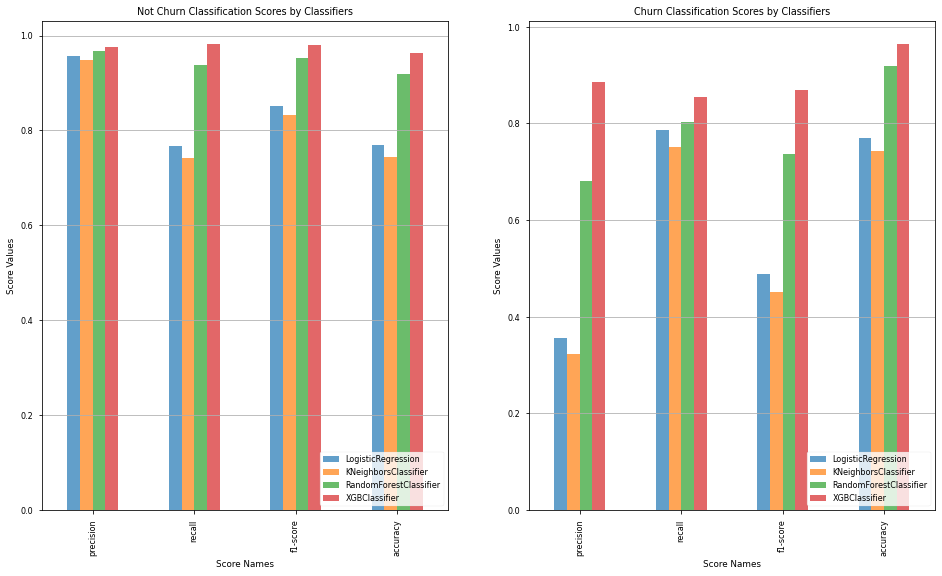

In [206]:
# Comparison scores plot for the models
plot_clf_rpt([df_tuned_not_churn_a, df_tuned_churn_a], ['Not Churn', 'Churn'])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>All four tuned models performance on par with each other in the precision area.</li>
            <li>Both random forest and XGBoost models produce remarkable scores, with XGBoost edge out slightly over the random forest model.</li>
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>XGBoost comes out on top of the chart across all four scores.</li>
            <li>KNN model came in last after the tunning.</li>
        </ul>
</div>

### Plot Confusion Matrix

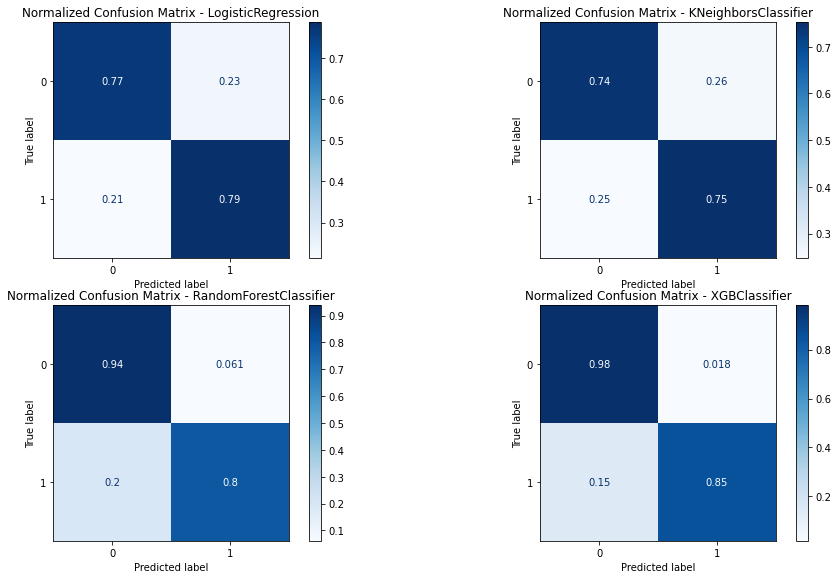

In [207]:
plot_conf_mat(tuned_classifiers_a, X_a_test_ohe, y_a_test)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>These plots confirm the finds in the classification report plots.</li>
        <li>Random forest and XGBoost classifiers should be considered for our final model, based on the recall scores performance.</li>
    </ul>
</div>

### Plot Comparison Classification Report Scores


***** Performance Gain/Loss Tuned vs Base Model *****



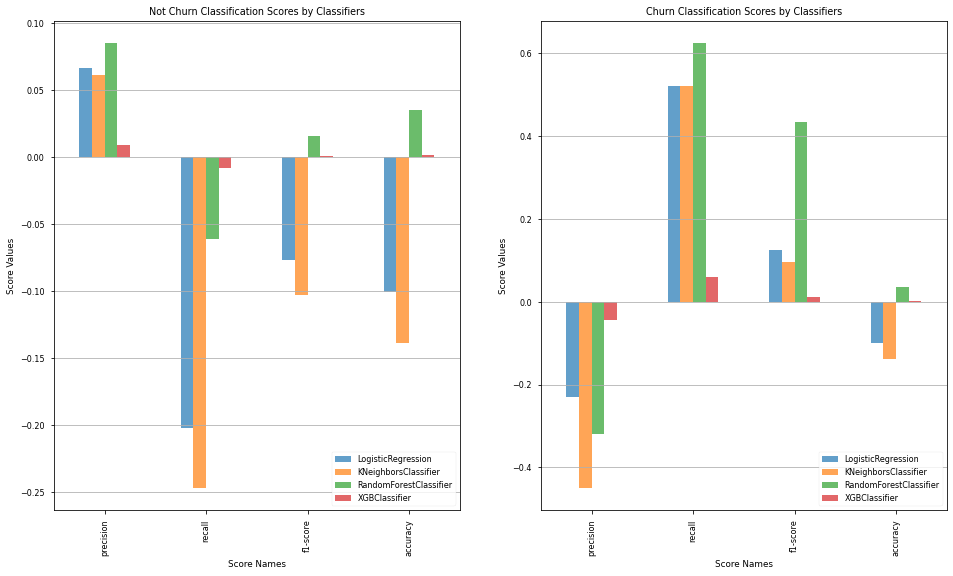

In [208]:
# plot performance changes after tuning models (tuned vs base)
df_nc_t_unt_a = df_tuned_not_churn_a.subtract(df_not_churn_a, axis='columns')
df_c_t_unt_a = df_tuned_churn_a.subtract(df_churn_a, axis='columns')

print('\n***** Performance Gain/Loss Tuned vs Base Model *****\n')
plot_clf_rpt([df_nc_t_unt_a, df_c_t_unt_a], ['Not Churn', 'Churn'])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>Gains in the precision department by the tuned models led to a loss in the recall scores.</li>
            <li>Grid search did not help logistic regression and KNN models as we saw a decrease in recall, f1_score and accuracy scores.</li>
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>Random forest benefits the most from the hyperparameters tuning.</li>
            <li>XGBoost did not improve much from tuning.</li>
        </ul>
    <p>--- Conclusion ---</p>
        <ul>
            <li>XGBoost lead the pack in the model outcomes.  We will use XGBoost classifier as our model of choice.</li>
        </ul>
</div>

***
## Compare XGBoost Models -  State vs Region

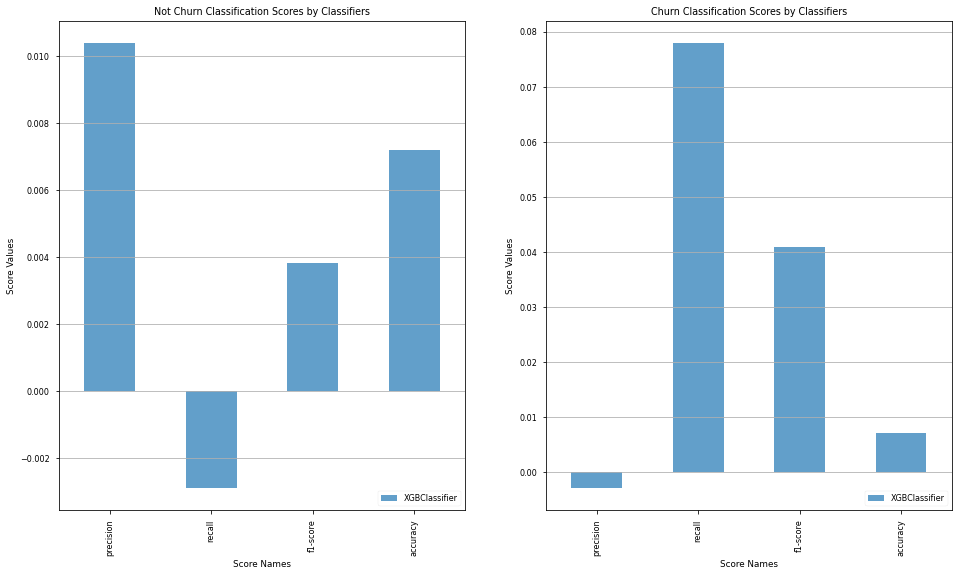

In [209]:
# Plot gain/loss chart between XGBoost in Model B and Model A
plot_clf_rpt([(df_tuned_not_churn_a.XGBClassifier - df_tuned_not_churn.XGBClassifier),
              (df_tuned_churn_a.XGBClassifier - df_tuned_churn.XGBClassifier)],
             ['Not Churn', 'Churn'])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>When we didn't group the State feature, the tuned version performed better than the version where we group the State feature.  Although there is a slight dropped in the recall score for the 'Not Churn' prediction, we see better performance for the other three scores.</li>
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>Similar gains is noticed in Model B.</li>
        </ul>
</div>

***
## Alternate Model -  Model Evaluation

### Model Validation

In [210]:
# Instantiate the object
xg_clf_a = xgb.XGBClassifier(max_depth=7, n_estimators=250, random_state=36)

# Fit the model
xg_clf_a.fit(X_a_train_smote, y_a_train_smote)

XGBClassifier(max_depth=7, n_estimators=250, random_state=36)

In [211]:
# Predit
y_a_train_pred = xg_clf_a.predict(X_a_train_smote)
y_a_test_pred = xg_clf_a.predict(X_a_test_ohe)

# Get accuracy scores
y_a_train_acc = accuracy_score(y_a_train_smote, y_a_train_pred)
y_a_test_acc = accuracy_score(y_a_test, y_a_test_pred)

print(f'\n***** Train Accuracy: {y_a_train_acc * 100}%. ' +
      f'Test Accuracy:{round(y_a_test_acc * 100,2)}% *****')


***** Train Accuracy: 100.0%. Test Accuracy:96.4% *****


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Both accuracy scores from train and test set are very close, which indicates that the model is not overfitting.</li>
        <li>The test accuracy score is higher for Model B, 96.4 vs 95.68. </li>
    </ul>
</div>

### Plot ROC Curve


***** AUC Score: 91.83% *****


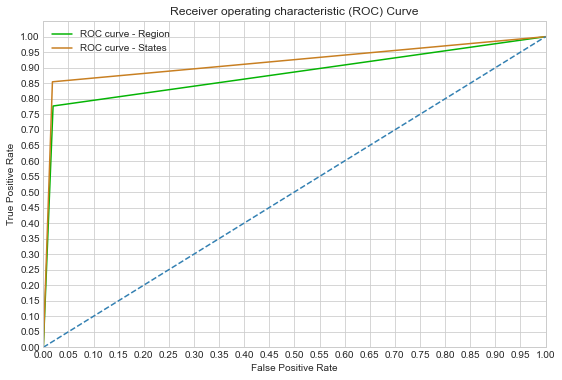

In [224]:
# Plot ROC curve
fpr_a, tpr_a, thresholds_a = roc_curve(y_a_test, y_a_test_pred)
print(f'\n***** AUC Score: {round(roc_auc_score(y_a_test, y_a_test_pred)*100,2)}% *****')

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,6))
    plt.plot(fpr, tpr, label="ROC curve - Region", color='#04B404')
    plt.plot(fpr_a, tpr_a, label="ROC curve - States", color='#C87F21')
    plt.plot([0,1],[0,1], color='#3380B2', linestyle='--')
    plt.xlim([0.0, 1.0], )
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend()
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>AUC score is also higher in this version, 91.83 vs 87.87 in the region model.</li>
        <li><b>Based on the all the scores, Model B seems to be a better classifier.  We will use it as our final model.<b></li>   
    </ul>
</div>

***
## Model Interpretation

### Feature Important

In [214]:
# load JS visualization code to notebook
shap.initjs()

# Compute shap values
explainer_a = shap.TreeExplainer(xg_clf_a, X_a_train_smote)
shap_values_a = explainer_a.shap_values(X_a_test_ohe)
      

100%|===================| 833/834 [05:42<00:00]        

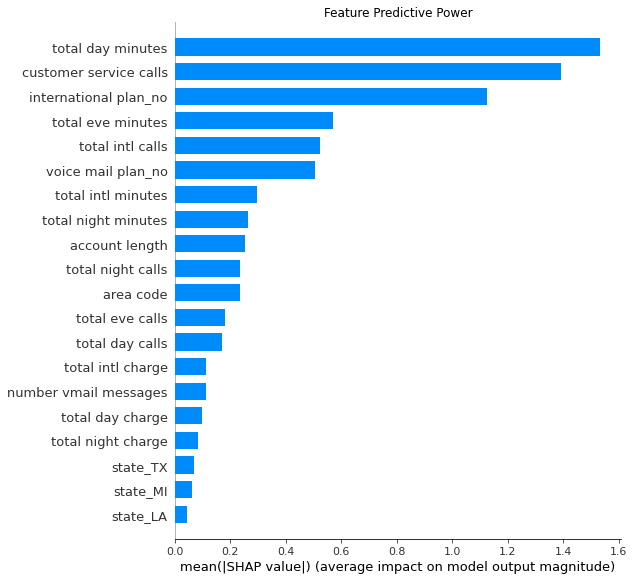

In [215]:
# plot feature important
fig = shap.summary_plot(shap_values_a, X_a_test_ohe, plot_type="bar", show=False)
plt.title('Feature Predictive Power')
plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The 'total day minutes' has the biggest impact on model outcome. It changes the predicted churn probability on average by 160% (1.6 on the x-axis). </li>
        <li>The second most important feature is the 'customer service calls' which on average chagnes the predicted churn probability by 150%.  The third most important feature is the 'international plan_no' feature.
    </ul>
</div>

### Shap Values Distribution by Features

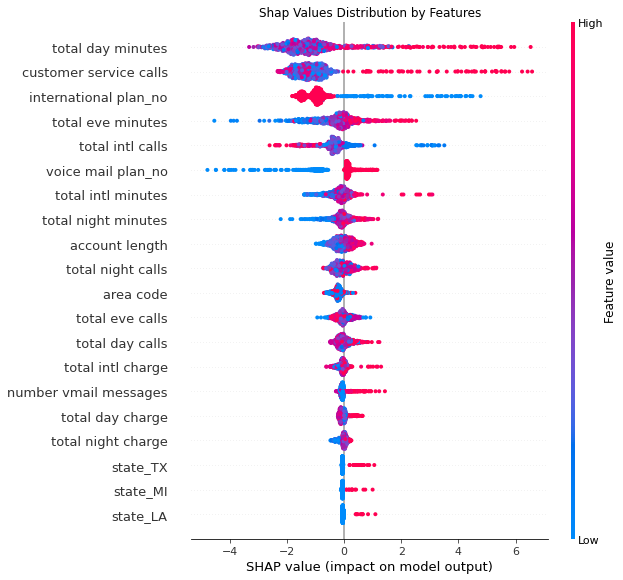

In [216]:
# Plot the Shap summary report which combines feature importance with feature effects
fig = shap.summary_plot(shap_values_a, X_a_test_ohe, show=False)
plt.title('Shap Values Distribution by Features')
plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Feature 'total day minutes' - The higher the actual feature values (red dots), the higher the prediction in the true churn rate.  On the hand, the lower ther actual feature values (blue dots), reduce the true churn rate.</li>
        <li>Feature 'customer service calls' - Customers with high number of calls to the service line, the higher the risk that the customers will Churn.</li>
        <li>Feature 'international plan_no - Customers without the international plan are more likely to churn than customers with the international plan.</li>
    </ul>
</div>

### Examine Individual Instance

In [217]:
# Find instances of 'Churn' & 'Not Churn'
n_churn_row_a = (y_a_test == 0).values.nonzero()[0][0]
churn_row_a = (y_a_test == 1).values.nonzero()[0][0]

In [219]:
# Examine features influnces on 'Not Churn' prediction
shap.force_plot(explainer_a.expected_value, shap_values_a[n_churn_row_a,:],
                X_a_test_ohe.iloc[n_churn_row_a,:])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>In this instance, the actual churn rate is False or 0.  Here we can how the the features in the model is wokring together to come to a false prediction.  'Account length' is pushing to a true prediction but it is being offset but the decreasing effect from 'toady day mintures', 'customer service alls' and other features.</li>
    </ul>
</div>

In [220]:
# Examine features influnces on 'Churn' prediction
shap.force_plot(explainer.expected_value, shap_values_a[churn_row_a,:],
                X_a_test_ohe.iloc[churn_row_a,:])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>In this instance, the actual value for the churn rate is True.  We can see how the model use the aggregate effects of 'customer service calls', 'total day minutes' and 'state_CA' to predict a True churn rate.</li>
    </ul>
</div>

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


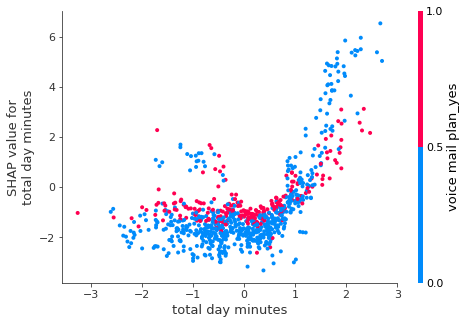

In [226]:
shap.dependence_plot("total day minutes", shap_values_a, X_a_test_ohe)

***
## Conclusion

<b> Our Classifier</b>
    <p>All of the selected supervised learning methods in this project are capable of tackling binary classification.  Each have their streghts and weakenesses in difference business cases.  In our case of predicting the Churn rate, the XGBosst classifier out performed the other three classifiers in term of accuracy, f1_score, precision, recall and the AUC score.</p>
<b>>Recommendations</b>    
    <p>Based on the available data, our model is able to identify which explanatory variables have the biggest impact on the Chrun rate.  We will look into the top three variables and make recommendations.<p>
<ol>
    <li>Total night Charge
        <p></p>
    </li>
    <li>'Region_West'</li>
    <li>'Account length</li>
<ol>

        



--- how to create the best method
for best in t.best
best_model = clf.best_estimators_
y_pred = best_model.predict(X_test)

tpr = tp / all positive
when the label is positive, how often does the classifier predict it as positive

fpr = fp / all neg
when the label is negative, how often does the classifier incorrectly predict it as positive


---
To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as RM (the average number of rooms per house in an area) changes. Vertical dispersion at a single value of RM represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by RAD (index of accessibility to radial highways) highlights that the average number of rooms per house has less impact on home price for areas with a high RAD value.

In [221]:
# feature_important = xg_clf.get_booster().get_score(importance_type='weight')
# keys = list(feature_important.keys())
# values = list(feature_important.values())

# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(
#                                                                 by = "score")
# data.plot(kind='barh')

In [222]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']